# ATO - Analytics

### Import Library

In [55]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [56]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [57]:
data = dataset.copy()

In [58]:
# data = data[data.index > '2020-11-01 00:00:00']

In [59]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090


## Data Insighs

In [60]:
data['last_RSI'] = ta.rsi(data["Close"], length=14)

In [61]:
daily_data = data.resample('D').agg({
        'Volume': 'sum',
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'last_RSI': 'last'
    })
daily_data.dropna(subset=['Close'], inplace=True)

In [62]:
daily_data["stoploss"] = daily_data.apply(lambda r: max(r["Open"] * 0.322 / 100, 3), axis=1)

In [63]:
daily_data["ATO_deal"] = daily_data.apply(lambda r: "None" if (r["High"] > r["Open"] + r["stoploss"] and r["Low"] < r["Open"] - r["stoploss"]) else ("Short" if r["Low"] < r["Open"] - r["stoploss"] else "Long"), axis=1)
daily_data["next_ATO_deal"] = daily_data["ATO_deal"].shift(-1)
daily_data["next_Open"] = daily_data["Open"].shift(-1)
daily_data.dropna(inplace=True)

In [64]:
daily_data

,Volume,Open,Close,High,Low,last_RSI,stoploss,ATO_deal,next_ATO_deal,next_Open
Date,,,,,,,,,,
2018-08-13,79327,943.5,954.2,954.6,942.3,78.080317,3.038070,Long,None,955.5
2018-08-14,79266,955.5,959.3,961.8,952.1,58.908168,3.076710,None,None,958.0
2018-08-15,89449,958.0,946.6,962.3,946.6,23.043416,3.084760,None,None,942.4
2018-08-16,71410,942.4,947.0,947.3,935.5,66.714887,3.034528,None,Short,952.2
2018-08-17,98531,952.2,947.0,954.6,945.0,39.751862,3.066084,Short,None,946.1
...,...,...,...,...,...,...,...,...,...,...
2025-10-28,408668,1885.0,1940.9,1947.9,1871.1,75.854700,6.069700,None,None,1943.8
2025-10-29,273188,1943.8,1947.0,1964.7,1936.1,43.785381,6.259036,None,Short,1947.0
2025-10-30,331492,1947.0,1927.0,1948.4,1910.5,49.780169,6.269340,Short,Short,1928.0


### Sự phân bổ  ATO deal (Long/Short/None)

Text(0.5, 1.0, 'Tỷ lệ tín hiệu: None / Long / Short')

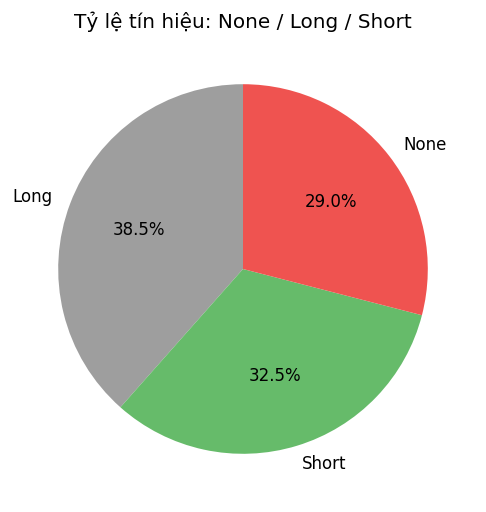

In [65]:
# Giả sử cột bạn muốn vẽ là 'signal'
counts = daily_data['next_ATO_deal'].value_counts(dropna=False)

# Đổi tên NaN hoặc None cho dễ đọc
counts.index = counts.index.astype(str)

# Vẽ pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#9e9e9e', '#66bb6a', '#ef5350']  # xám, xanh, đỏ
)
plt.title("Tỷ lệ tín hiệu: None / Long / Short")

### Sự ảnh hưởng của last RSI tới ATO deal hôm sau

In [73]:
def group_by_last_RSI(r):
    if r["last_RSI"] < 30:
        if r['next_ATO_deal'] == "None":
            return "group I"
        if r['next_ATO_deal'] == "Long":
            return "group II"
        if r['next_ATO_deal'] == "Short":
            return "group III"
    elif 30 <= r["last_RSI"] <= 70:
        if r['next_ATO_deal'] == "None":
            return "group IV"
        if r['next_ATO_deal'] == "Long":
            return "group V"
        if r['next_ATO_deal'] == "Short":
            return "group VI"
    else:
        if r['next_ATO_deal'] == "None":
            return "group VII"
        if r['next_ATO_deal'] == "Long":
            return "group VIII"
        if r['next_ATO_deal'] == "Short":
            return "group IX"

Text(0.5, 1.0, 'Sự ảnh hưởng của last RSI tới next_ATO_deal')

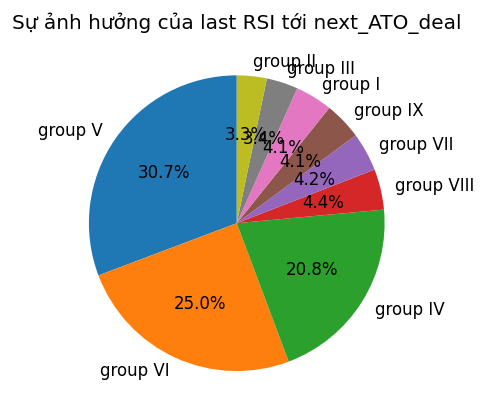

In [74]:
ana_data = daily_data.copy()
ana_data['last_RSI_group'] = ana_data.apply(lambda r: group_by_last_RSI(r), axis=1)
ana_data.dropna(inplace=True)
counts = ana_data['last_RSI_group'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Sự ảnh hưởng của last RSI tới next_ATO_deal")

### Sự ảnh hưởng của vị trí giá next_Open tới ATO deal hôm sau

In [67]:
def group_by_next_Open(r):
    if r["next_Open"] > r['EMA_fast']:
        if r['next_Open'] > r["Close"]:
            if r['next_ATO_deal'] == "None":
                return "group I"
            if r['next_ATO_deal'] == "Long":
                return "group II"
            if r['next_ATO_deal'] == "Short":
                return "group III"
        else:
            if r['next_ATO_deal'] == "None":
                return "group IV"
            if r['next_ATO_deal'] == "Long":
                return "group V"
            if r['next_ATO_deal'] == "Short":
                return "group VI"
    else:
        if r['next_Open'] > r["Close"]:
            if r['next_ATO_deal'] == "None":
                return "group VII"
            if r['next_ATO_deal'] == "Long":
                return "group VIII"
            if r['next_ATO_deal'] == "Short":
                return "group IX"
        else:
            if r['next_ATO_deal'] == "None":
                return "group X"
            if r['next_ATO_deal'] == "Long":
                return "group XI"
            if r['next_ATO_deal'] == "Short":
                return "group XII"

Text(0.5, 1.0, 'Vị trí giá next_Open tới next_ATO_deal')

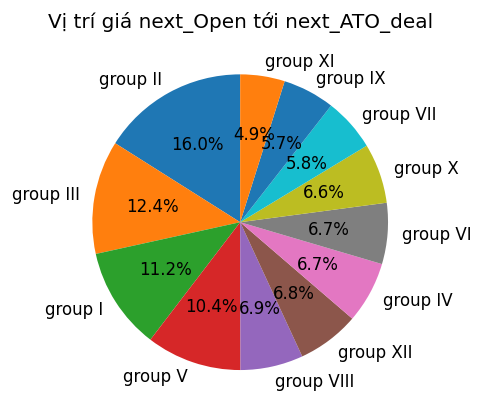

In [68]:
ana_data = daily_data.copy()
ana_data['EMA_fast'] = ta.ema(ana_data["Close"], length=22)
ana_data['EMA_low'] = ta.ema(ana_data["Close"], length=200)
ana_data['next_Open_group'] = ana_data.apply(lambda r: group_by_next_Open(r), axis=1)
ana_data.dropna(inplace=True)
counts = ana_data['next_Open_group'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Vị trí giá next_Open tới next_ATO_deal")

### Sự ảnh hưởng của Body size and IBS tới ATO deal hôm sau

In [69]:
ana_data = daily_data.copy()
ana_data['body_size'] = abs(ana_data['Close'] - ana_data['Open'])
ana_data['ibs'] = ana_data.apply(lambda r: (r['Close'] - r['Low']) / (r['High'] - r['Low']), axis=1)

Text(0.5, 1.0, 'Sự ảnh hưởng của Body size and IBS tới ATO deal hôm sau')

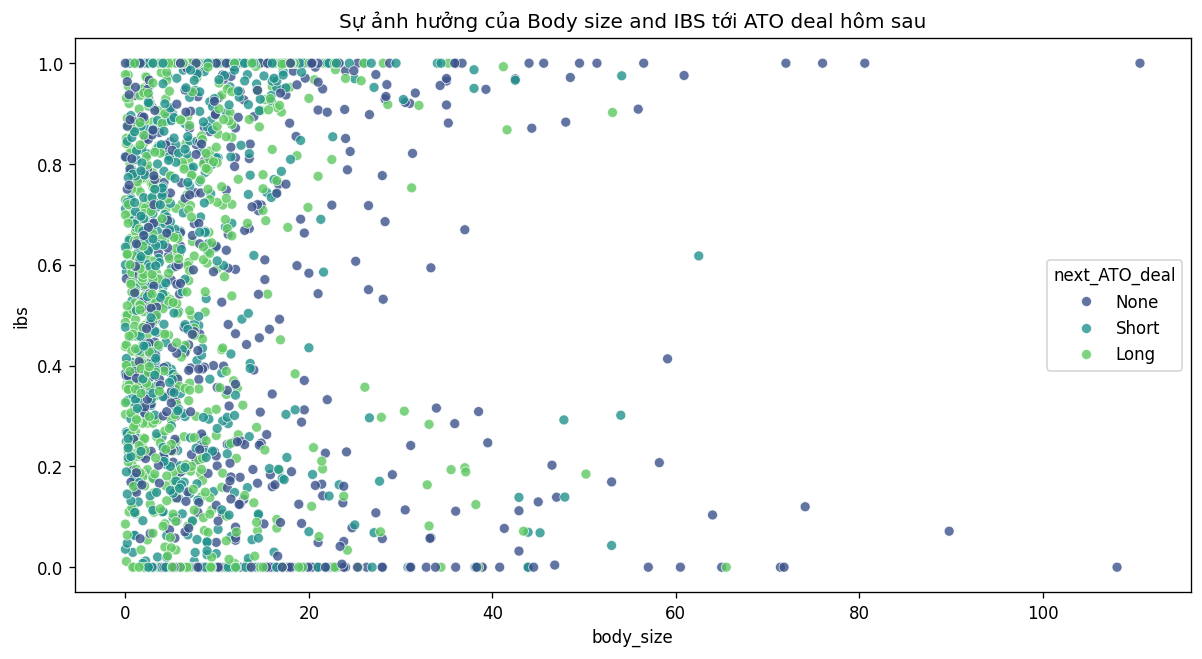

In [70]:
sns.scatterplot(
    data=ana_data[['body_size', 'ibs', 'next_ATO_deal']],
    x='body_size',
    y='ibs',
    hue='next_ATO_deal',
    palette='viridis',
    alpha=0.8
)
plt.title('Sự ảnh hưởng của Body size and IBS tới ATO deal hôm sau')

### Sự ảnh hưởng của RSI & EMA diff tới ATO deal hôm sau

In [71]:
ana_data = daily_data.copy()
ana_data['day_RSI'] = ta.rsi(ana_data["Close"], length=14)
ana_data['EMA_fast'] = ta.ema(ana_data["Close"], length=10)
ana_data['EMA_low'] = ta.ema(ana_data["Close"], length=200)
ana_data['EMA_diff'] = ana_data['EMA_fast'] - ana_data['EMA_low']

Text(0.5, 1.0, 'Next ATO Deal Distribution')

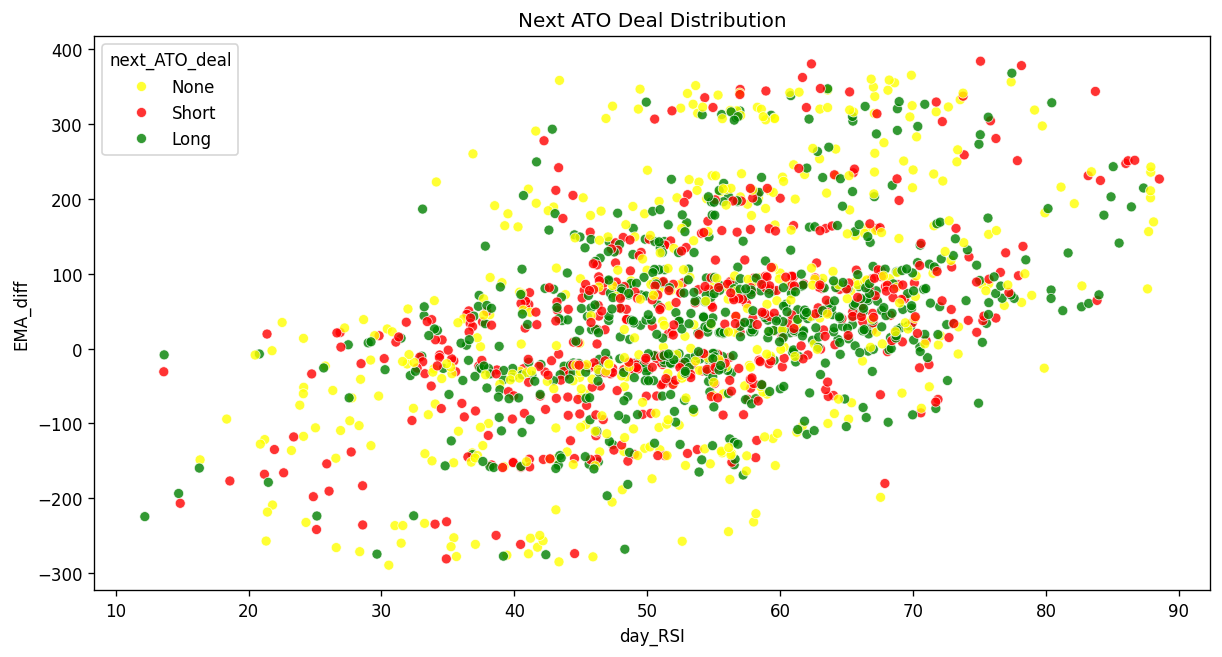

In [72]:
sns.scatterplot(
    data=ana_data[['day_RSI', 'EMA_diff', 'next_ATO_deal']],
    x='day_RSI',
    y='EMA_diff',
    hue='next_ATO_deal',
    palette={'Long':'green','Short':'red','None':'yellow'},
    alpha=0.8
)
plt.title('Next ATO Deal Distribution')